In [1]:
import OpenEXR as exr
import matplotlib.pyplot as plt
import numpy
import numpy as np

In [2]:
exrfile = exr.InputFile('/mnt/d/PerceptionOutput/this_is_the_end/solo_1/sequence.0/step0.camera.Normal.exr')
header = exrfile.header()
dw = header['dataWindow']
isize = (dw.max.y - dw.min.y + 1, dw.max.x - dw.min.x + 1)

In [3]:
print(f'dw: {dw}')

dw: (0, 0) - (1098, 823)


In [4]:
import Imath
import numpy as np

In [5]:
channelData = dict()

for c in header['channels']:
    channel = exrfile.channel(c, Imath.PixelType(Imath.PixelType.FLOAT))
    channel = np.fromstring(channel, dtype=np.float32)
    channel = np.reshape(channel, isize)

    channelData[c] = channel

/tmp/ipykernel_6046/1570041188.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  channel = np.fromstring(channel, dtype=np.float32)


In [6]:
colorChannels = ['R', 'G', 'B', 'A'] if 'A' in header['channels'] else ['R', 'G', 'B']

In [7]:
print(f"R: {colorChannels[0]}")

R: R


In [8]:
img = np.concatenate([channelData[c][...,np.newaxis] for c in colorChannels], axis=2)

In [13]:
print (f'normal at [302,589]: {img[302,589]}')

normal at [302,589]: [0.5        0.99240386 0.5868241  1.        ]


In [14]:
import matplotlib.pyplot as plt

In [15]:
print (f'max: {np.max(img)}')

max: 1.0


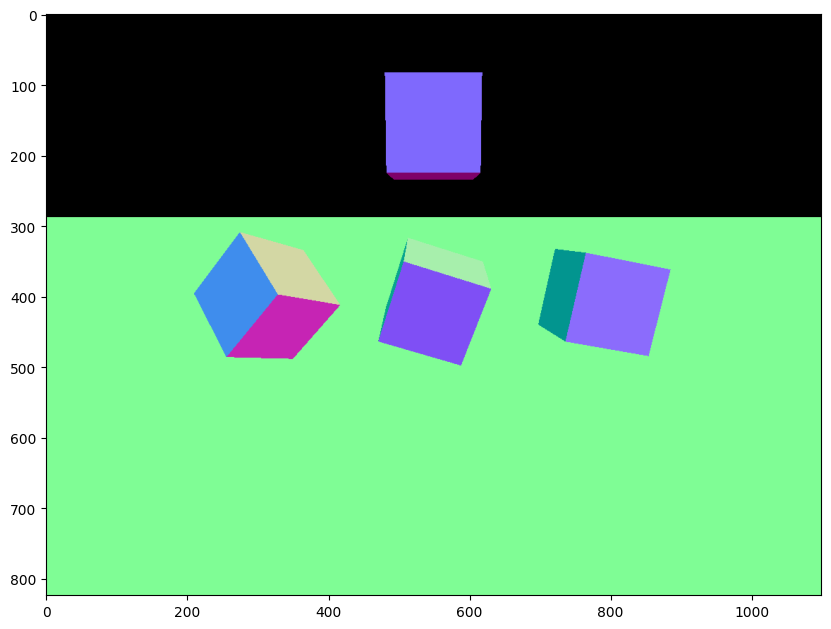

In [16]:
# img = img / np.max(img) * 255
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img[:,:,:])


In [13]:
import fiftyone as fo

In [14]:
heatmap = np.random.randint(256, size=(128, 128), dtype=np.uint8)

In [15]:
sample = fo.Sample(filepath='/mnt/d/PerceptionOutput/this_is_the_end/solo_1/sequence.0/step0.camera.png')

In [16]:
sample["heatmap"] = fo.Heatmap(map=heatmap)

In [17]:
print(sample)

<Sample: {
    'id': None,
    'media_type': 'image',
    'filepath': '/mnt/d/PerceptionOutput/this_is_the_end/solo_1/sequence.0/step0.camera.png',
    'tags': [],
    'metadata': None,
    'heatmap': <Heatmap: {
        'id': '6319f132d0c7e7dc23aa86ca',
        'tags': BaseList([]),
        'map': array([[142, 143, 153, ...,  25,  47,  38],
               [165, 132, 111, ...,  64,  96,  98],
               [ 41, 217, 102, ...,  19, 215, 195],
               ...,
               [221, 250, 101, ..., 211,  28,  11],
               [182,  82,  48, ...,  71, 153, 223],
               [240, 106, 165, ..., 207,  56, 105]], dtype=uint8),
        'range': None,
    }>,
}>


In [ ]:
def _project_pt_to_pixel_location_perspective(pt, projection_matrix, img_dimensions):
    projected_pt = projection_matrix.dot(pt)

    if projected_pt[2] != 0:
        projected_pt /= projected_pt[2]

    return np.array(
        [
            int(-(projected_pt[0] * img_dimensions[0] / 2.0 + (img_dimensions[0] * 0.5))),
            int((projected_pt[1] * img_dimensions[1]) / 2.0 + (img_dimensions[1] * 0.5))
        ]
    )

In [ ]:
def _project_pt_to_pixel_location_ortho(pt, projection_matrix, img_dimensions):
    # have to flip y value
    projection_matrix[1][1] = -projection_matrix[1][1]

    temp = projection_matrix.dot(pt)
    return np.array(
        [
            int((temp[0] + 1) * 0.5 * img_dimensions[0]),
            int((temp[1] + 1) * 0.5 * img_dimensions[1])
        ]
    )

In [ ]:
def add_bbox_to_image(image, box, projection, orthographic = False):
    projection_function = (
        _project_pt_to_pixel_location_ortho if orthographic else _project_pt_to_pixel_location_perspective)

    fll = projection_function()

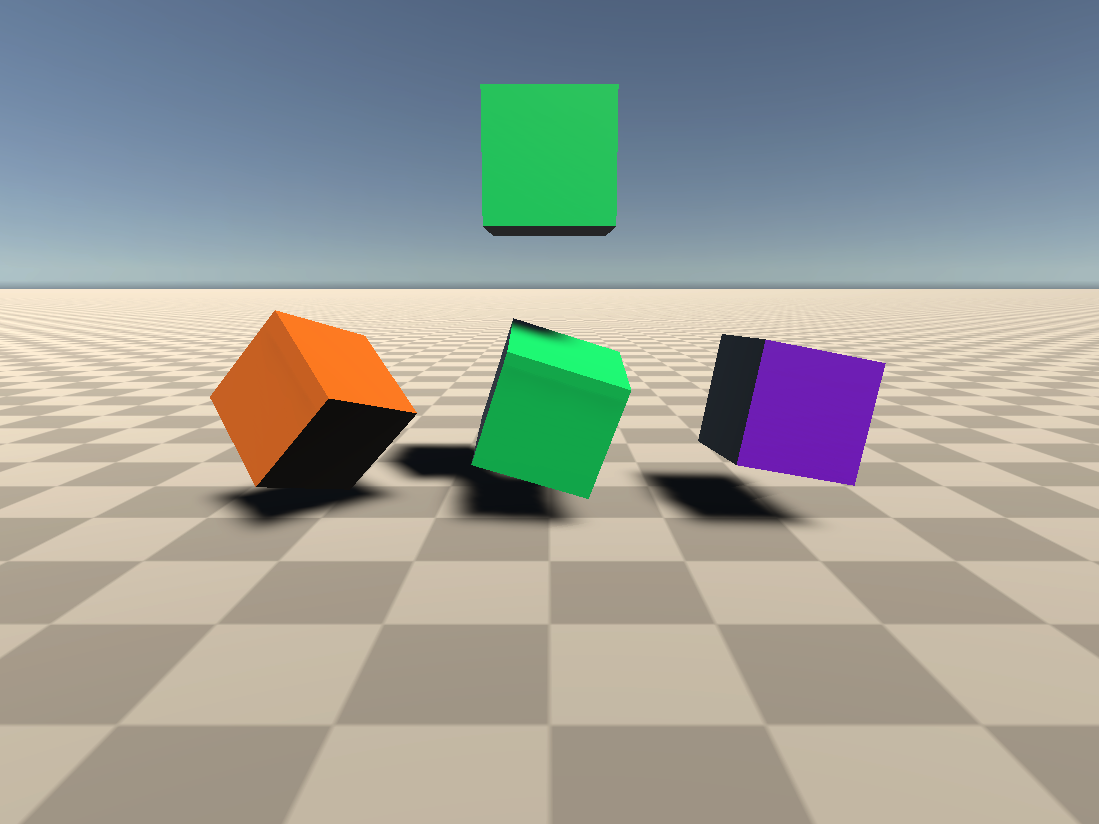

In [1]:
from PIL import Image, ImageDraw

# Draw the image
img_path = '/mnt/d/PerceptionOutput/this_is_the_end/solo_1/sequence.0/step0.camera.png'
img = Image.open(img_path)
img.show()

In [2]:
from pyquaternion import Quaternion
import numpy as np

ortho = False
matrix = np.array(
    [
        [1.298865, 0.0, 0.0],
        [0.0, 1.73234534, 0.0],
        [0.0, 0.0, -1.0006001]
    ]
)

translation = [-2.0, 0.0570817664, 6.082495]
size = [1.00000012, 1.00000036, 1.00000048]
rotation = Quaternion(0.147543147, -0.8995135, -0.3475102, 0.2198711)
print(f'rotation: {rotation}')

rotation: +0.148 -0.900i -0.348j +0.220k


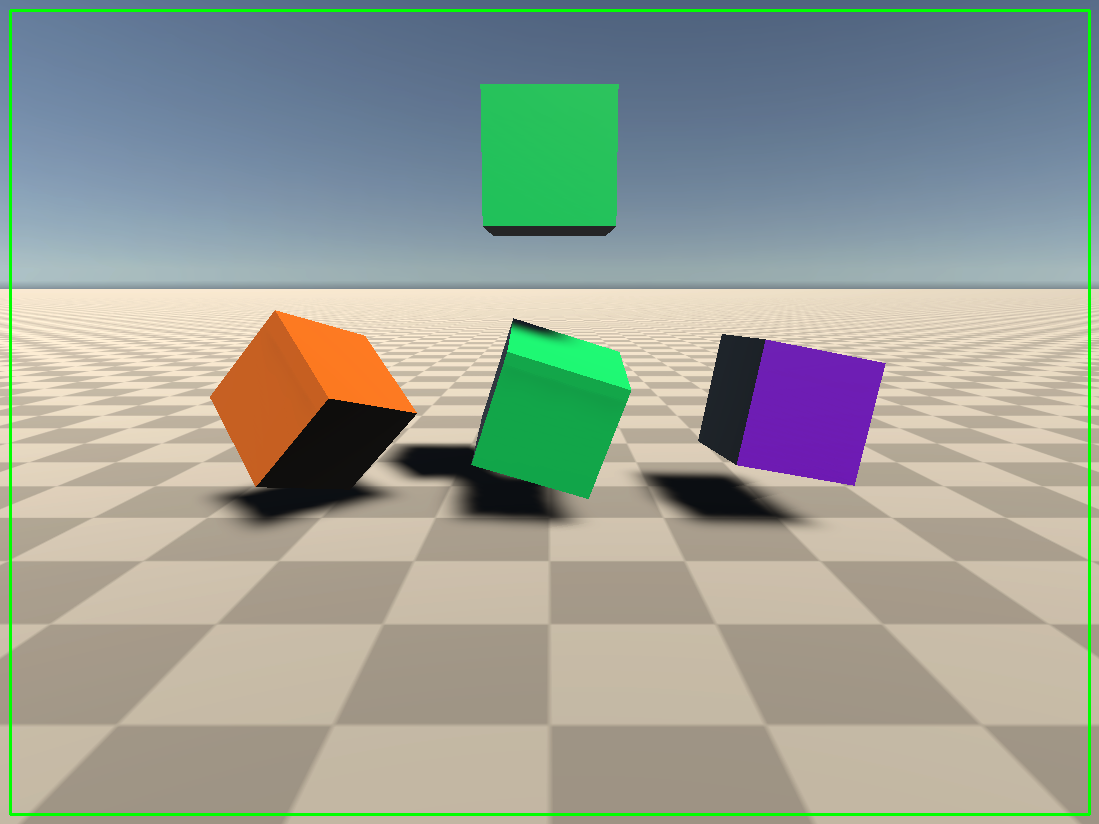

In [3]:
draw = ImageDraw.Draw(img)

ful = (10, 10)
fll = (10, img.size[1] - 10)
fur = (img.size[0] - 10, 10)
flr = (img.size[0] - 10, img.size[1] - 10)

draw.line(ful + fur + flr + fll + ful, fill = (0, 255, 0, 255), width=3)
# draw.line((0, img.size[1], img.size[0], 0), fill=128)
img.show()

In [4]:
def box_pt_to_world(box_center, box_rotation, pt):
    return np.array(box_center) + box_rotation.rotate(pt)

In [5]:
from pysolo_extensions.viewers.solo_fiftyone import BBox3D

bbox = BBox3D(translation, size, rotation)
projected = bbox.project_to_image_coordinates(img.size, matrix, ortho)


print(f'projected: {projected}')

projected: [[209 397]
 [256 487]
 [328 398]
 [275 310]
 [304 410]
 [350 489]
 [417 413]
 [365 335]]


fll: (209, 397)
bll: (304, 410)


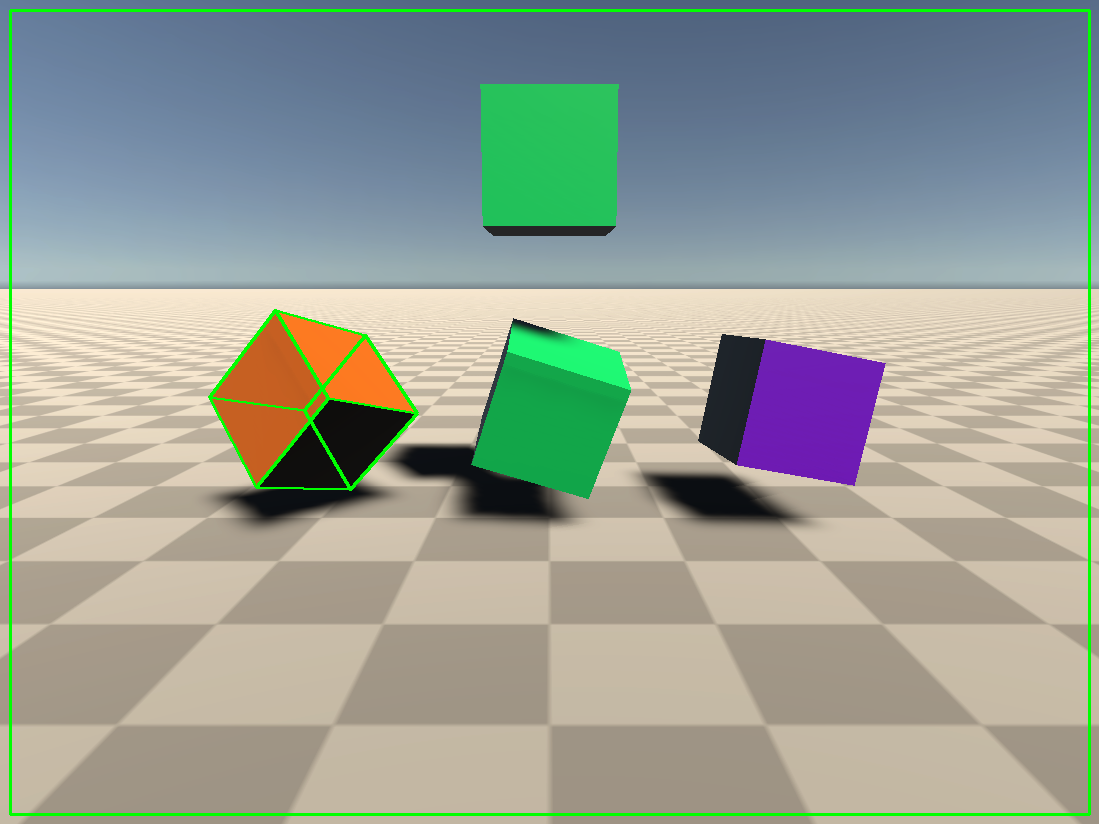

In [7]:
draw = ImageDraw.Draw(img)

fll = (projected[0][0], projected[0][1])
ful = (projected[1][0], projected[1][1])
fur = (projected[2][0], projected[2][1])
flr = (projected[3][0], projected[3][1])

bll = (projected[4][0], projected[4][1])
bul = (projected[5][0], projected[5][1])
bur = (projected[6][0], projected[6][1])
blr = (projected[7][0], projected[7][1])

print(f'fll: {fll}')
print(f'bll: {bll}')

draw.line(ful + fur + flr + fll + ful, fill = (0, 255, 0, 255), width=3)
draw.line(bul + bur + blr + bll + bul, fill = (0, 255, 0, 255), width=3)

draw.line(ful + bul, fill = (0, 255, 0, 255), width=3)
draw.line(fll + bll, fill = (0, 255, 0, 255), width=3)
draw.line(fur + bur, fill = (0, 255, 0, 255), width=3)
draw.line(flr + blr, fill = (0, 255, 0, 255), width=3)
# draw.line((0, img.size[1], img.size[0], 0), fill=128)
img.show()

In [87]:
path = '/mnt/d/PerceptionOutput/this_is_the_end/solo_3/sequence.1/step0.camera.instance segmentation.png'

In [88]:
import PIL.Image

In [277]:
img = PIL.Image.open(path)
img.show()

In [115]:
import numpy as np

n_img = np.asanyarray(img)

color_code = {
    (0, 0, 0, 255) : 0,
    (255, 0, 0, 255) : 1,
    (0, 74, 255, 255) : 2,
    (149, 255, 0, 255) : 3,
    (255, 0, 223, 255) : 4,
}

for k in color_code.keys():
    print(f'k: {k}')
    l = np.asarray(k)
    print(f'l: {l}')

colors = np.fromiter([np.asarray(l) for l in color_code.keys()], dtype=np.dtype((int, 4))) # color_code.keys(), dtype=tuple)
color_ids = np.fromiter(color_code.values(), dtype=int)

print(f'colors: {colors}')
print(f'color ids: {color_ids}')


k: (0, 0, 0, 255)
l: [  0   0   0 255]
k: (255, 0, 0, 255)
l: [255   0   0 255]
k: (0, 74, 255, 255)
l: [  0  74 255 255]
k: (149, 255, 0, 255)
l: [149 255   0 255]
k: (255, 0, 223, 255)
l: [255   0 223 255]
colors: [[  0   0   0 255]
 [255   0   0 255]
 [  0  74 255 255]
 [149 255   0 255]
 [255   0 223 255]]
color ids: [0 1 2 3 4]


In [116]:
result = np.empty((n_img.shape[0], n_img.shape[1]), dtype=int)
result[:] = -1
print(f'empty result: {result}')

empty result: [[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [135]:
b = np.where(n_img==[255,0,0,255])
print(b)
# print(n_img[b])

(array([  0,   0,   0, ..., 823, 823, 823]), array([   0,    0,    0, ..., 1096, 1097, 1098]), array([1, 2, 3, ..., 3, 3, 3]))


In [126]:
print(f'n_img[0]: {n_img[0]}')

x,y,idx = np.where((n_img == colors[:,None,None,:]).all(3))


print(f'x: {x}')
print(f'y: {y}')
print(f'index: {idx}')

print(f'x[0]: {x[90000]}')
print(f'y[0]: {y[90000]}')
print(f'index[0]: {idx[90000]}')

print(f'x size: {x.size}')
print(f'y size: {y.size}')
print(f'idx size: {idx.size}')

for xo in range(200):
    print(f'{x[xo]}\t')

# result[x,y] = color_ids[idx]

n_img[0]: [[  0   0   0 255]
 [  0   0   0 255]
 [  0   0   0 255]
 ...
 [  0   0   0 255]
 [  0   0   0 255]
 [  0   0   0 255]]
x: [0 0 0 ... 4 4 4]
y: [  0   0   0 ... 581 581 581]
index: [  0   1   2 ... 678 679 680]
x[0]: 0
y[0]: 81
index[0]: 981
x size: 905576
y size: 905576
idx size: 905576
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	
0	


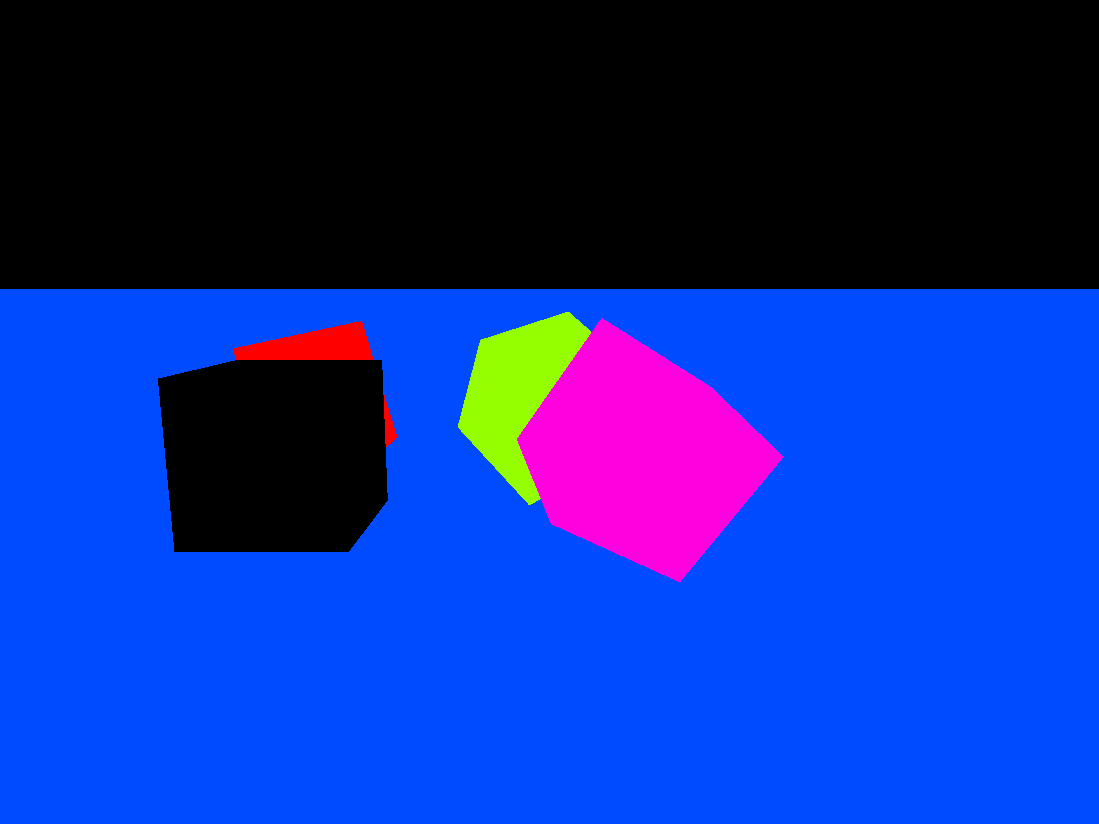

converted palette: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 51, 0, 0, 102, 0, 0, 153, 0, 0, 204, 0, 0, 255, 0, 0, 0, 51, 0, 51, 51, 0, 102, 51, 0, 153, 51, 0, 204, 51, 0, 255, 51, 0, 0, 102, 0, 51, 102, 0, 102, 102, 0, 153, 102, 0, 204, 102, 0, 255, 102, 0, 0, 153, 0, 51, 153, 0, 102, 153, 0, 153, 153, 0, 204, 153, 0, 255, 153, 0, 0, 204, 0, 51, 204, 0, 102, 204, 0, 153, 204, 0, 204, 204, 0, 255, 204, 0, 0, 255, 0, 51, 255, 0, 102, 255, 0, 153, 255, 0, 204, 255, 0, 255, 255, 0, 0, 0, 51, 51, 0, 51, 102, 0, 51, 153, 0, 51, 204, 0, 51, 255, 0, 51, 0, 51, 51, 51, 51, 51, 102, 51, 51, 153, 51, 51, 204, 51, 51, 255, 51, 51, 0, 102, 51, 51, 102, 51, 102, 102, 51, 153, 102, 51, 204, 102, 51, 255, 102, 51, 0, 153, 51, 51, 153, 51, 102, 153, 51, 153, 153, 51, 204, 153, 51, 255, 153, 51, 0, 204, 51, 51, 204, 51, 102, 204, 51, 153, 204, 51, 204, 204, 51, 255, 204, 51, 0, 255, 51, 51, 255, 51, 102, 255, 51, 153, 255, 51, 204, 255, 51, 255,

In [85]:
rgb = img.convert("RGB")
rgb.show()
converted = rgb.convert("P")
print(f'converted palette: {converted.getpalette()}')

In [72]:
img = img.convert("RGB")
print(f'img mode: {img.mode}')
p_img = PIL.Image.Image()
p_img.mode = 'P'
p_img.palette = PIL.ImagePalette.ImagePalette(palette=palette)
converted = img.quantize(palette=p_img)
print(f'converted mode: {converted.mode}')
print(f'converted palette: {converted.getpalette()}')
#img.palette = PIL.ImagePalette.ImagePalette(mode="RGBA", palette=palette)
#img = img.convert("P")
#print(f'now img mode: {img.mode}')
#print(f'img palette: {img.getpalette()}')

img mode: RGB


None

ValueError: palette argument must be image with mode 'P'

In [34]:
converted = img.quantize(palette=img)

ValueError: only RGB or L mode images can be quantized to a palette

In [146]:
baked_img = np.arrange(0, 4)

baked_image = np.array(
    [
        [
            [0,0,0,255], [255,0,0,255]
        ],
        [
            [0,255,0,255], [0,0,255,255]
        ]
    ])

img = PIL.Image.fromarray(baked_image)
img.show()

TypeError: Cannot handle this data type: (1, 1, 4), <i8

In [147]:
path = '/mnt/d/tmp/simple4.png'
img = PIL.Image.open(path)
img.show()

In [148]:
array = np.array(img)
print(f'array: {array}')

array: [[[ 17  17  17]
  [  0 255   0]]

 [[  0   0 255]
  [255   0   0]]]


In [172]:
# a = np.where(array == ([255, 0, 0], axis=2), 1, 0)
# print(f'a: {a}')

# mask = np.all(array == [255, 0, 0], axis=2)
# print(mask)

colors_container = np.zeros(shape=[array.shape[0], array.shape[1]])
print(f'colors_container: {colors_container}')

new_img = np.where(np.all(array == [255, 0, 0], axis=2), 1, 0)
print(new_img)

colors_container: [[0. 0.]
 [0. 0.]]
[[0 0]
 [0 1]]


In [174]:
shape = array.shape[:2]
total_shape = shape[0] * shape[1]
print(f'shape: {shape}')
print(f'total shape: {total_shape}')

shape: (2, 2)
total shape: 4


In [257]:
palette_data=[
    0, 0, 255,
    255, 0, 0,
    17, 17, 17,
    0, 255, 0,
]

num_entries_in_pillow_palette = 256
num_bands = len("RGB")
num_entries_in_palette_data = len(palette_data) // num_bands
palette_data.extend([0,0,0] * (num_entries_in_pillow_palette - num_entries_in_palette_data))
print(palette_data)
print(f'length: {len(palette_data)}')

[0, 0, 255, 255, 0, 0, 17, 17, 17, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [258]:
arbitrary_size = 16, 16
palimage = PIL.Image.new('P', arbitrary_size)
palimage.putpalette(palette_data)

In [259]:
path = '/mnt/d/tmp/simple4.png'
img = PIL.Image.open(path)
img.show()

In [260]:
def quantitize_palette(silf, palette):
    silf.load()

    # use palette from reference image
    palette.load()
    if palette.mode != "P":
        raise ValueError("bad mode for palette image")
    if silf.mode != "RGB" and silf.mode != "L":
        raise ValueError(
            "only RGB or L mode images can be quantized to a palette"
            )
    im = silf.im.convert("P", 0, palette.im)
    # the 0 above means turn OFF dithering

    # Really old versions of Pillow (before 4.x) have _new
    # under a different name
    try:
        return silf._new(im)
    except AttributeError:
        return silf._makeself(im)

In [261]:
img.convert("RGB")
img.load()

In [262]:
palimage.load()

In [263]:
im = img.im.convert("P", 0, palimage.im)

In [264]:
n_img = np.asanyarray(im)
print(n_img)

[2 3 0 1]


In [265]:
print(im)

In [266]:
convo = img._new(im)

In [267]:
print(convo)

<PIL.Image.Image image mode=P size=2x2 at 0x7F6C17938A90>


In [268]:
convo.show()

In [269]:
n_img_old = np.asarray(img)
print(n_img_old)

[[[ 17  17  17]
  [  0 255   0]]

 [[  0   0 255]
  [255   0   0]]]


In [271]:
print(convo.getpalette())

[0, 0, 255, 255, 0, 0, 17, 17, 17, 0, 255, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [273]:
occlusion_values = [0, 0.25, 0.75, 1]

print (n_img)

[2 3 0 1]


In [276]:
x = np.choose(n_img, occlusion_values)
print(x)

[0.75 1.   0.   0.25]


In [299]:
path = '/mnt/d/PerceptionOutput/this_is_the_end/solo_3/sequence.1/step0.camera.instance segmentation.png'

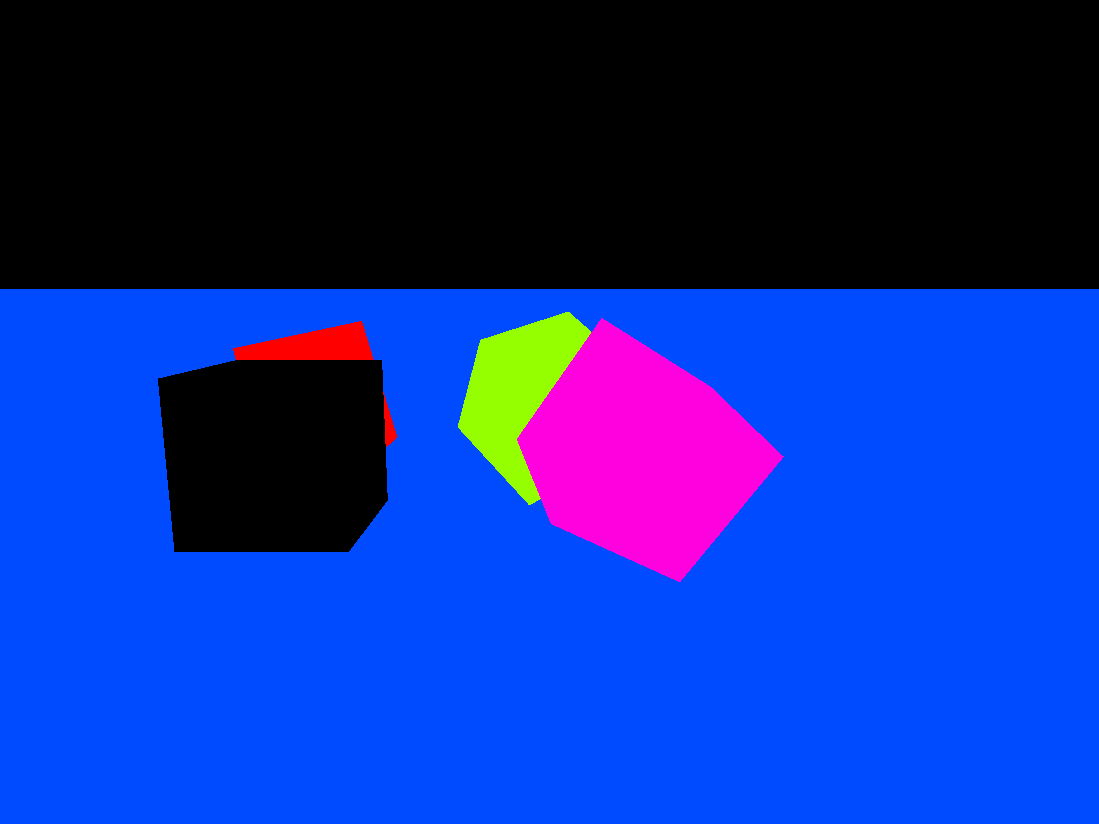

In [300]:
img = PIL.Image.open(path)
img.show()

In [301]:
palette_data=[
    0, 0, 0,
    255, 0, 0,
    0, 74, 255,
    149, 255, 0,
    255, 0, 223
]

num_entries_in_pillow_palette = 256
num_bands = len("RGB")
num_entries_in_palette_data = len(palette_data) // num_bands
palette_data.extend([0,0,0] * (num_entries_in_pillow_palette - num_entries_in_palette_data))
print(palette_data)
print(f'length: {len(palette_data)}')


[0, 0, 0, 255, 0, 0, 0, 74, 255, 149, 255, 0, 255, 0, 223, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [302]:
arbitrary_size = 16, 16
palimage = PIL.Image.new('P', arbitrary_size)
palimage.putpalette(palette_data)

In [303]:
img.load()
palimage.load()

In [304]:
im = img.im.convert("P", 0, palimage.im)

In [305]:
n_img = np.asanyarray(im)
print(n_img)

[0 0 0 ... 2 2 2]


In [306]:
convo = img._new(im)

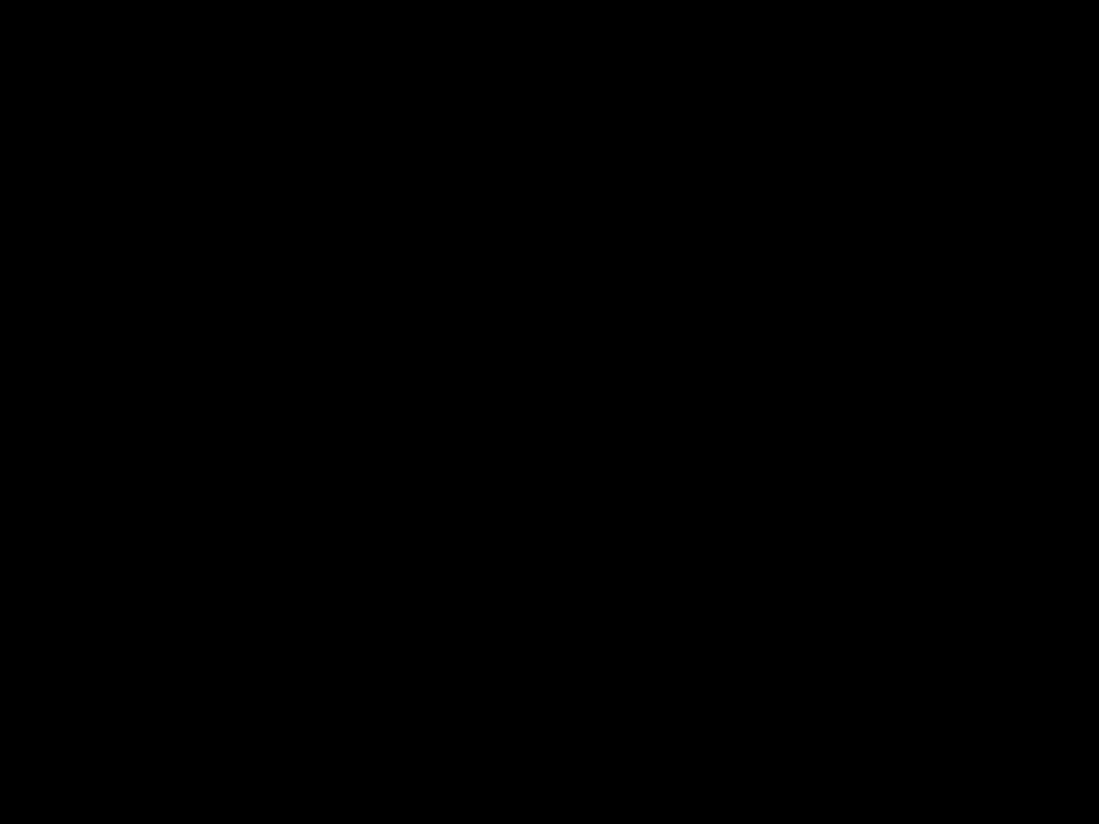

In [307]:
convo.show()

In [308]:
oc_vals = [0, 0.213, 0, 0.506, 1]
x = np.choose(n_img, oc_vals)
print(x)

[0. 0. 0. ... 0. 0. 0.]


In [309]:
x = x.reshape(img.height, img.width)

In [310]:
import matplotlib.pyplot as plt

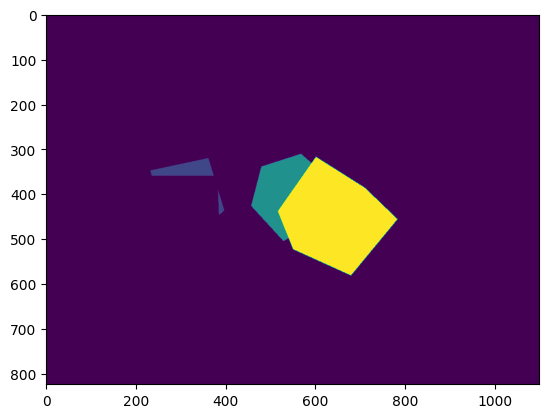

In [315]:
plt.imshow(x, cmap='viridis')
plt.show()

In [317]:
palette_data = np.full(256 * 3, 0, dtype=np.uint8)
print(palette_data)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [319]:
palette_data[3] = 255
print(palette_data)

[  0   0   0 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [326]:
palette_data[0:15] = [
            0, 0, 0,
            255, 0, 0,
            0, 74, 255,
            149, 255, 0,
            255, 0, 223
        ]
print(palette_data)

[  0   0   0 255   0   0   0  74 255 149 255   0 255   0 223   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

In [ ]:
v = np.array(0 * 32)